# Starbucks Capstone Challenge 





## Overview

This is a simulation for the customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.





## Data Sets

The data is contained in three files:

#### Portfolio  file that contains offer ids and meta data about each offer

    1-id  - offer id
    2-offer_type - type of offer ie BOGO, discount, informational
    3-difficulty -  minimum required spend to complete an offer
    4-reward - reward given for completing an offer
    5-duration  - time for offer to be open, in days
    6-channels 

#### Profile  file that contains demographic data for each customer

    1. age - customer's age
    2. became_member_on - account creation date
    3. gender - customers's gender
    4. id - customer's id
    5. income - customer's income

#### Transcript  file that contains records for transactions, offers received, offers viewed, and offers completed

    1-event  - record description (ie transaction, offer received, offer viewed, etc.)
    2-person  - customer id
    3-time  - time in hours since start of offer. The data begins at time t=0
    4-value  - either an offer id or transaction amount depending on the record



 

# Problem Statement / Metrics

 As long as not all users receive the same offer, I need to build a recommendation system that provides the most suitable offers for each user .

# Data Exploration

in this part we'll explore the datasets to understand more the data and the relation between different varables.

In [1]:
#import the needed liberaries

import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from collections import OrderedDict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score



/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# read in the json files

portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
#Let's Explore the offers' portfolio dataset, we can see that offers' channels are concatenated in one column and needs splitting
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
#Now let's explore the customers' profile dataset, there are some NaN  values that need cleansing
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
# let's view the shape of our dataset
profile.shape

(17000, 5)

In [6]:
#some statistics about the numerical columns
profile.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,17000.0,6.253141e+01,26.738580,18.0,45.0,58.0,73.0,118.0
became_member_on,17000.0,2.016703e+07,11677.499961,20130729.0,20160526.0,20170802.0,20171230.0,20180726.0
income,14825.0,6.540499e+04,21598.299410,30000.0,49000.0,64000.0,80000.0,120000.0


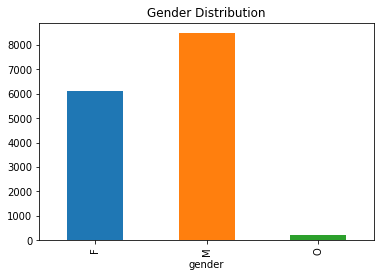

In [7]:
#let's view the gender distribution
profile.groupby(['gender']).count()['age'].plot(kind="bar");
plt.title("Gender Distribution");

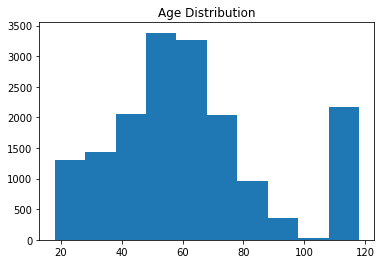

In [8]:
#let's check the age distribution, we can see that there're some records above 100 yrs need to be removed as suspected to be wrong entries
plt.hist(profile['age'])
plt.title("Age Distribution");

In [9]:
def convert_to_datetime(time):
    """
    INPUT:
        Date in str format
    OUTPUT:
        Datetime object
        """
    return datetime.strptime(str(time), '%Y%m%d')

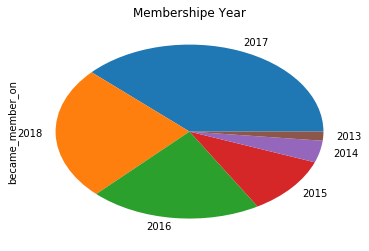

In [10]:

membership_date = profile['became_member_on'].apply(convert_to_datetime)

year = membership_date.apply(lambda elem: elem.year).value_counts()
year *= 100 / year.sum()
year.plot(kind="pie");
plt.title("Membershipe Year");

In [11]:
#now let's explore the transcript dataset
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [12]:
#see the shape of the dataset
transcript.shape

(306534, 4)

In [13]:
#statistics about event column
transcript['event'].describe().transpose()

count          306534
unique              4
top       transaction
freq           138953
Name: event, dtype: object

In [14]:
#check number of unique users who are using the offers
len(transcript['person'].unique())

17000

In [15]:
# see the different status for the offers, we can see that there are 4 status for each customer per offer 
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

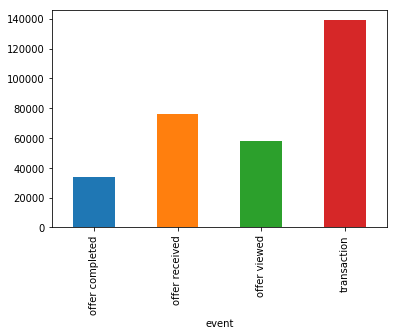

In [16]:
#see number of customers in each transaction
transcript.groupby(['event']).count()['person'].plot(kind="bar");

# Cleaning The Data 


### Cleaning Portfolio dataset
    1- Rename the id column to 'offer_id'
    2- Encoding the channels column and offer_type column
    3- Removing the old columns (channels and offer_type)

In [17]:
def clean_Pdata(portfolio=portfolio):
    """ 
    INPUT:
        DataFrame containing offer ids and meta data about each offer (duration, type, etc.)
    OUTPUT:
        DataFrame containing offer ids and meta data about each offer (duration, type, etc.) after encoding the data 
    """
    portfolio = portfolio.rename(columns={'id': 'offer_id'})
    offer_type=pd.get_dummies(portfolio.offer_type)
    portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    portfolio_new = pd.concat([portfolio, offer_type], axis=1, sort=False)
    portfolio_clean = portfolio_new.drop(columns=['offer_type', 'channels'])
    return portfolio_clean

In [18]:
Clean_Portfolio=clean_Pdata(portfolio)

In [19]:
#check the dataframe after cleansing
Clean_Portfolio.head(2)

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0




### Cleaning Profile Dataset


1. removing null values
2. removing the outliers in age column
3. mapping the id of the customer to a simpler form of 'user_id'

In [20]:
profile.head(2)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0


In [21]:
# Drop null values from profile dataset, we can see that the max age is now 101 only
profile.dropna(inplace=True)
profile.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,14825.0,5.439352e+01,17.383705,18.0,42.0,55.0,66.0,101.0
became_member_on,14825.0,2.016689e+07,11885.653317,20130729.0,20160520.0,20170802.0,20171230.0,20180726.0
income,14825.0,6.540499e+04,21598.299410,30000.0,49000.0,64000.0,80000.0,120000.0


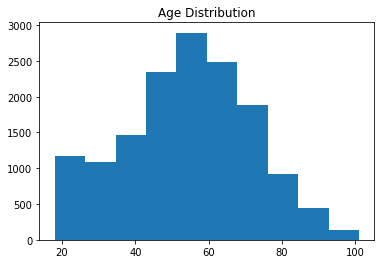

In [22]:
#let's check the age distribution after the high ages were removed
plt.hist(profile['age'])
plt.title("Age Distribution");

In [23]:
# Dropping any possible duplicates
profile.id=profile.id.drop_duplicates()

In [24]:
#  this function to map the profile id to a simple user_id column 
def id_mapper():
    '''
    input:
    the column of IDs we need to map
    output:
    more simple user IDs for the customers
    '''
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in profile['id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded

id_encoded = id_mapper()

profile['user_id'] = id_encoded

# show header
profile.head(2)

,age,became_member_on,gender,id,income,user_id
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2


### Cleaning Transcript Dataset

1. extract the offer_id and the amount of money from value column
2. encode the 'event' column
3. drop the old columns 'value', 'event'
4. convert time column to days instead of hours
5. dropping the old event, value columns


In [25]:
transcript.head(2)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [26]:
def clean_Tdata(transcript):
    '''
    input:
    transcript data frame
    output:
    a cleaned version of transcript dataframe after encoding the event columns and extracting the offer id and amount from value column and converting the time column to be in days instead of hours
    '''
    event=pd.get_dummies(transcript.event)    
    value_items=transcript['value'].apply(pd.Series)
    value_items['offer_id'] = value_items['offer_id'].fillna(value_items['offer id'])
    transcript = transcript.rename(columns={'person': 'user_id'})
    transcript['time'] /= 24.0
    transcript= transcript.rename(columns={'time':'time_in_days'})
    transcript_new = pd.concat([value_items,event,transcript], axis=1, sort=False)
    transcript_clean = transcript_new.drop(columns=['event','value','offer id'])
    return transcript_clean
    

In [27]:
#veiwing the data after preprocessing
transcript_new=clean_Tdata(transcript)
transcript_new.head()

,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction,user_id,time_in_days
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,78afa995795e4d85b5d9ceeca43f5fef,0.0
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,a03223e636434f42ac4c3df47e8bac43,0.0
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,e2127556f4f64592b11af22de27a7932,0.0
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,8ec6ce2a7e7949b1bf142def7d0e0586,0.0
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,68617ca6246f4fbc85e91a2a49552598,0.0


In [28]:
#checking the transaction rows
test=transcript_new[(transcript_new['transaction']==1)]
test.head()

,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction,user_id,time_in_days
12654,0.83,NaN,NaN,0,0,0,1,02c083884c7d45b39cc68e1314fec56c,0.0
12657,34.56,NaN,NaN,0,0,0,1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0
12659,13.23,NaN,NaN,0,0,0,1,54890f68699049c2a04d415abc25e717,0.0
12670,19.51,NaN,NaN,0,0,0,1,b2f1cd155b864803ad8334cdf13c4bd2,0.0
12671,18.97,NaN,NaN,0,0,0,1,fe97aa22dd3e48c8b143116a8403dd52,0.0


In [29]:
#view the shape of the new dataframe
transcript_new.shape

(306534, 9)

## Merging All DataFrames Together 

In [30]:
#merging the 3 dataframes together transcript_new, clean_portfolio, profile using User_id and Offer_id
trans_port = pd.merge(transcript_new, Clean_Portfolio ,how='left', on = 'offer_id')# merging transcript_new, clean_portfolio on offer_id
df = pd.merge(trans_port, profile ,left_on = 'user_id',right_on='id') # merging the new merged dataframe 'all_transcript' with profile dataframe on user_id
df = df.drop(columns=['user_id_x'])
df=df.rename(columns={'user_id_y': 'user_id','id': 'old_user_id'})


In [31]:
#view the shape of the new merged dataframe
df.shape

(272762, 24)

In [32]:
#view a sample of the new dataframe

df.head(2)

,amount,offer_id,reward_x,offer completed,offer received,offer viewed,transaction,time_in_days,difficulty,duration,...,social,bogo,discount,informational,age,became_member_on,gender,old_user_id,income,user_id
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,0.00,5.0,7.0,...,0.0,1.0,0.0,0.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2
1,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,0,1,0,0.25,5.0,7.0,...,0.0,1.0,0.0,0.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2


In [33]:
# dropping any possible duplicates
df=df.drop_duplicates()
df.shape

(272388, 24)

In [34]:
#Viewing the data for a single user as a check, hear we can see that same user with same offer_if is repeated in many rows each with a different response, next step i'll group all these records together
df.loc[df['user_id']==2] .transpose()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
amount,NaN,NaN,19.89,NaN,17.78,NaN,NaN,19.67,29.72,23.93,NaN,NaN,NaN,21.72,NaN,NaN,26.56,NaN
offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,NaN,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,NaN,f19421c1d4aa40978ebb69ca19b0e20d
reward_x,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,5,NaN,NaN
offer completed,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
offer received,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0
offer viewed,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
transaction,0,0,1,0,1,0,0,1,1,1,0,0,0,1,0,0,1,0
time_in_days,0,0.25,5.5,5.5,6,7,9,9.25,10,15.75,17,17,21,21.25,21.25,21.25,22.25,24.25
difficulty,5,5,NaN,5,NaN,0,0,NaN,NaN,NaN,10,10,5,NaN,10,5,NaN,5
duration,7,7,NaN,7,NaN,3,3,NaN,NaN,NaN,7,7,5,NaN,7,5,NaN,5


## Hear we will extract a dataframe for the Viewed Offers Only

as any completed offer without being received and viewed may be a coincidence, that's why the reference dataset for our model will be the viewed offers only

In [35]:
# extracting a new dataframe for all viewed offers with a flag either this offer completed or not
df_all_grouped=df.groupby(['user_id','offer_id'],as_index=False)['offer completed','offer viewed','offer received'].sum()
Customers_viewed_offers=df_all_grouped.loc[(df_all_grouped['offer viewed']==1)]
Customers_completed_offers=Customers_viewed_offers.drop(columns=['offer viewed','offer received'])# dropping the columns we don't need 
Customers_completed_offers.head() # viewing a sample of the new dataframe


,user_id,offer_id,offer completed
2,2,5a8bc65990b245e5a138643cd4eb9837,0
3,2,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
4,2,ae264e3637204a6fb9bb56bc8210ddfd,1
5,2,f19421c1d4aa40978ebb69ca19b0e20d,1
6,3,2906b810c7d4411798c6938adc9daaa5,0


# Building a Recommendation System

## 	1. Rank Based Recommendations

### This is to be used for any new user as it ranks the offers based on the usage.

In [36]:
def get_top_offers(n, df=Customers_completed_offers):
    '''
    INPUT:
    n - (int) the number of top offers to return
    df - (pandas dataframe) the users -offers dataframe 
    
    OUTPUT:
    top_offers - (list) A list of the top 'n' offers 
    
    '''
    
    Top_offers = df.groupby('offer_id',as_index=False)['user_id'].count().sort_values(by='user_id',ascending=False)
    Top_offers = Top_offers.rename(columns={'user_id':'usage_cnt'})
    

    return Top_offers.head(n) # Return the top offers

In [37]:
# test the function , to return top 3 offers
get_top_offers(3)

,offer_id,usage_cnt
9,fafdcd668e3743c1bb461111dcafc2a4,4436
4,4d5c57ea9a6940dd891ad53e9dbe8da0,4423
1,2298d6c36e964ae4a3e7e9706d1fb8c2,4370


##  2. User-User Based Collaborative Filtering 

### Here we'll create a User_Item Matrix from User_IDs and Offer_IDs

In [38]:
# create the user-offer matrix 

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with user_id, offer_id, offer completed columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and offer ids on the columns with the number of times a user completed an offer 
    '''
    user_item=pd.pivot_table(df.drop_duplicates(),index='user_id',values= 'offer completed', columns=['offer_id'],aggfunc= np.sum, fill_value=0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [39]:
# view the shape of the matrix
user_item.shape

(14820, 10)

In [40]:
# view sample of the matrix
user_item.head(2)

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
user_id,,,,,,,,,,
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,1,1,0


###  here we'll get the Offer_IDs that have been used by a specific user

In [41]:
def get_user_offers(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by offers: 
    
    OUTPUT:
    offer_ids - (list) a list of the offer ids used by the user
    
    Description:
    Provides a list of the offer_ids that have been used by a user
    '''
    
    offer_ids = list(user_item.loc[user_id][user_item.loc[user_id]>0].index.values)#list of offer ids that have been used by the user
    return offer_ids # return the offer ids 

In [42]:
#test the function with user_id= 10
user_offers=get_user_offers(10)
user_offers

['2298d6c36e964ae4a3e7e9706d1fb8c2', '9b98b8c7a33c4b65b9aebfe6a799e6d9']

### Here we'll Sort all Offer_IDs based on Customers' Usage for these offers

In [43]:
def sorted_offers (offers_list,df=Customers_completed_offers):
    '''
    input:
    list of offers list to be sorted and the data frame of all users and offers 
    output:
    list of offer sorted descending by usage
    '''
    sorted_off=list(df.groupby(['offer_id'],as_index=False)['offer completed'].sum().sort_values(by=['offer completed'], ascending=False)['offer_id'])
    
    sorted_off_new = [elem for elem in sorted_off if elem in offers_list]
    return sorted_off_new

In [44]:
off = ['ae264e3637204a6fb9bb56bc8210ddfd', 'f19421c1d4aa40978ebb69ca19b0e20d']
test = sorted_offers(off)
test

['f19421c1d4aa40978ebb69ca19b0e20d', 'ae264e3637204a6fb9bb56bc8210ddfd']

### This function  provides the most similar users to each user Ranked based on Similarity, and number of used offers per user

In [45]:
def get_top_sorted_users(user_id, df=Customers_completed_offers,user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) of user_ids and offer_ids with the completion flag
    user_item - (pandas dataframe) matrix of users by offers: 
            
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    user_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    completed_cnt - the number of offers used by the user 
                    
    Other Details - sort the neighbors_df by the similarity and then by number of offers used where 
                    highest of each is higher in the dataframe
     
    '''
    user_x = user_item.loc[user_id]
    sim = np.dot(user_x, user_item.transpose())
    df_sim = pd.DataFrame(list(zip(user_item.index.values,sim)),columns =['user_id', 'Similarity'])
    no_interactions = df.groupby(['user_id'], as_index = False).count()[['user_id', 'offer_id']].rename(columns={'offer_id':'completed_cnt'})

    neighbors_df = pd.merge(df_sim, no_interactions).sort_values(by=['Similarity', 'completed_cnt'], ascending=False)
    neighbors_df['user_id'] != user_id
    neighbors_df.drop(neighbors_df[neighbors_df['user_id'] == user_id].index, inplace = True)
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [46]:
#testing the similarity function
rec=get_top_sorted_users(2)
rec.head(10)

,user_id,Similarity,completed_cnt
3624,3806,5,2
7148,7520,5,2
12580,13238,5,2
8401,8830,5,1
9756,10250,5,1
3374,3544,4,5
215,227,4,4
289,307,4,4
672,712,4,4
2541,2672,4,4


### This Function loops through the users based on closeness to the input user_id, For each user - finds the top used offers and provides them as recommendations

In [47]:
def user_user_recs(user_id, m):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by offer id
    
    Description:
    Loops through the users based on closeness to the input user_id,For each user - 
    finds the top used offers and provides them as recommendations; Does this until m recommendations are found

   Notes:
    * Choose the users that have the top count of offers used 
    before choosing those with fewer counts.

    * Choose offers that have higher number of total usage 
    before choosing those with fewer total usage. 
    '''
 
    df_sim = get_top_sorted_users(user_id)  
    offers_list = []

    for u in df_sim['user_id']:
        sim_users_offers = get_user_offers(u)
        if len(offers_list) < m:
            offers_list = offers_list + sim_users_offers
            offers_list = list(dict.fromkeys(offers_list))
        else:
            break
 
    offers_list_sorted = sorted_offers(offers_list)
    recs = offers_list_sorted[:m]
 
    return recs

In [48]:
#testing the user_user_recs recommendation function
user_id=2
user_user_recs(user_id, m=5)

['2298d6c36e964ae4a3e7e9706d1fb8c2',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '4d5c57ea9a6940dd891ad53e9dbe8da0']

In [49]:
df.head()

,amount,offer_id,reward_x,offer completed,offer received,offer viewed,transaction,time_in_days,difficulty,duration,...,social,bogo,discount,informational,age,became_member_on,gender,old_user_id,income,user_id
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,0.00,5.0,7.0,...,0.0,1.0,0.0,0.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2
1,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,0,1,0,0.25,5.0,7.0,...,0.0,1.0,0.0,0.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2
2,19.89,NaN,NaN,0,0,0,1,5.50,NaN,NaN,...,NaN,NaN,NaN,NaN,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2
3,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,0,5.50,5.0,7.0,...,0.0,1.0,0.0,0.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2
4,17.78,NaN,NaN,0,0,0,1,6.00,NaN,NaN,...,NaN,NaN,NaN,NaN,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2


In [50]:
# extracting the valid offers only where the offer was received and veiwed by the user
valid_offers_df=pd.merge(df,Customers_completed_offers)
valid_offers_df.shape
valid_offers_df=valid_offers_df.rename(columns={'offer completed':'offer_succussful'})
valid_offers_df=valid_offers_df.drop(columns=['offer received', 'offer viewed','amount','transaction'])
valid_offers_df.head(10)

,offer_id,reward_x,offer_succussful,time_in_days,difficulty,duration,reward_y,web,email,mobile,social,bogo,discount,informational,age,became_member_on,gender,old_user_id,income,user_id
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,5.50,5.0,7.0,5.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2
1,5a8bc65990b245e5a138643cd4eb9837,NaN,0,7.00,0.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2
2,5a8bc65990b245e5a138643cd4eb9837,NaN,0,9.00,0.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2
3,ae264e3637204a6fb9bb56bc8210ddfd,10.0,1,21.25,10.0,7.0,10.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2
4,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,21.25,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2
5,2906b810c7d4411798c6938adc9daaa5,NaN,0,0.00,10.0,7.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,3
6,2906b810c7d4411798c6938adc9daaa5,NaN,0,0.75,10.0,7.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,3
7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,21.75,5.0,7.0,5.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,3
8,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,21.75,10.0,10.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,3
9,2906b810c7d4411798c6938adc9daaa5,2.0,1,20.75,10.0,7.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,4


In [76]:
#replacing null values in reward column with 0
valid_offers_df['reward_y'] = np.where(np.isnan(valid_offers_df.reward_y), 0, valid_offers_df.reward_y)

## Model Implementation and Refinement

####  In the next section, I'll build a supervised Machine Learning Model on the valid offers data set to predict whether an offer will be completed or not.
I will use three models and compare their results:
1. DecisionTreeClassifier
2. GradientBoostingClassifier
3. Random forest model


In [77]:
#select the model features
features = valid_offers_df[["time_in_days","difficulty","duration","reward_y","web","email","mobile","social","bogo","discount","informational","age","became_member_on","income"]]

In [80]:
#splitting the data into train and test data sets (80% training and 20% testing)
X_train, X_test, y_train, y_test = train_test_split(features
                                                    ,valid_offers_df['offer_succussful'], test_size=0.20, random_state=30)
X=features
y=valid_offers_df['offer_succussful']

In [98]:
def evaluate_model_performance(model_name,X_train, y_train, X_test, y_test):
    '''
    input: the model to be used
    X_train, y_train, X_test, y_test
    output:
    output containg training score and testing score
    '''
    output = {}
    clf = model_name   
    clf = clf.fit(X_train, y_train)
    predictions_test = clf.predict(X_test)
    predictions_train = clf.predict(X_train)
     
    #calculate training accuracy 
    output['training_score']= clf.score(X_train,y_train)
    
    #calculate testing accuracy 
    output['testing_score']= clf.score(X_test,y_test)
    
    return output

### 1. Trying DecisionTreeClassifier

In [99]:
#applying DecisionTreeClassifier
evaluate_model_performance( DecisionTreeClassifier() ,X_train, y_train, X_test, y_test)

{'training_score': 1.0, 'testing_score': 0.81890660592255127}

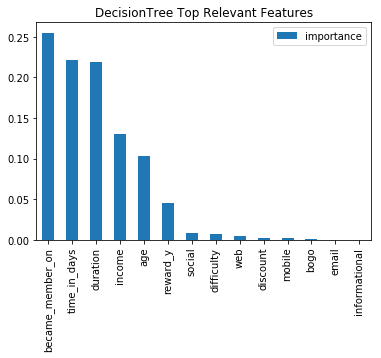

In [100]:
# Show the importance of the features
Model_res=DecisionTreeClassifier().fit(X_train,y_train)
importances = Model_res.feature_importances_

# Plot
feat_imp = pd.DataFrame(Model_res.feature_importances_, index=features.columns, columns=['importance']).sort_values('importance',ascending=False)
feat_imp.plot.bar()
plt.title('DecisionTree Top Relevant Features')
plt.show()

###  2 .Trying GradientBoostingClassifier

In [101]:
# applying GradientBoostingClassifier
evaluate_model_performance( GradientBoostingClassifier() ,X_train, y_train, X_test, y_test)

{'training_score': 0.86213606055572689, 'testing_score': 0.85981397114654523}

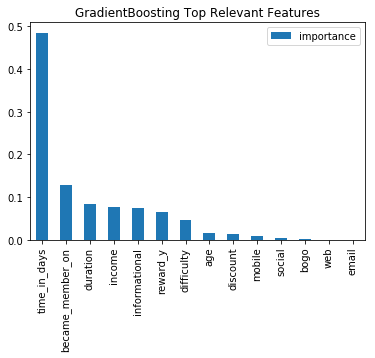

In [102]:
# Show the importance of the features
Model_res=GradientBoostingClassifier().fit(X_train,y_train)
importances = Model_res.feature_importances_

# Plot
feat_imp = pd.DataFrame(Model_res.feature_importances_, index=features.columns, columns=['importance']).sort_values('importance',ascending=False)
feat_imp.plot.bar()
plt.title('GradientBoosting Top Relevant Features')
plt.show()

### 3. Trying RandomForestClassifier

In [103]:
# applying RandomForestClassifier
RF_Acc=evaluate_model_performance(RandomForestClassifier(),X_train, y_train, X_test, y_test)
RF_Acc

{'training_score': 0.99167121467384856, 'testing_score': 0.85136674259681089}

### Improvement

#### Using GridSearchCV to find the best number of estimators for the RandomForestClassifier

In [60]:
param_grid = { 
    'n_estimators': [70,100, 150]
  
}

In [104]:

clf = GridSearchCV(estimator=RandomForestClassifier(), 
                    param_grid=param_grid,
                    cv=5,
                    refit=True,
                    error_score=0,
                    n_jobs=-1)

clf.fit(X_train, y_train)
optimised_random_forest = clf.best_estimator_
optimised_random_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [105]:
#Now let's test the best estimator model
output = {}
    
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train)
     
#calculate training accuracy 
output['training_score']= clf.score(X_train,y_train)
    
#calculate testing accuracy 
output['testing_score']= clf.score(X_test,y_test)

In [106]:
output

{'training_score': 1.0, 'testing_score': 0.87186788154897499}

#### Here both training score and testing score improved by tuning the number of estimators

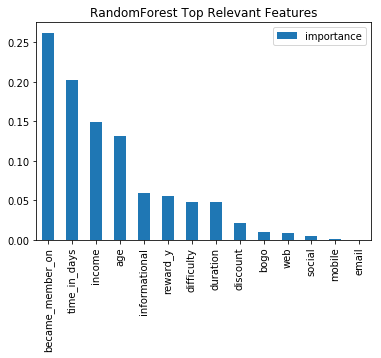

In [63]:
# Show the importance of the features
Model_res=RandomForestClassifier(n_estimators=150).fit(X_train,y_train)
importances = Model_res.feature_importances_

# Plot
feat_imp = pd.DataFrame(Model_res.feature_importances_, index=features.columns, columns=['importance']).sort_values('importance',ascending=False)
feat_imp.plot.bar()
plt.title('RandomForest Top Relevant Features')
plt.show()

In [ ]:
model_performance = []


###### Conclusion

As we can see in all the above work
1. the best clf is randome forest
2. the membership date is one of the most important features.
3. the Testing accuracy is 87% after refinement, and in can be more improved if more features were added to the customers profile like customer segmentation based on monthly money spent in Starbucks, Fan flag,..etc
